[SAMPLE CODE]
# Pythonプログラムの基本：H2Oai OSSによる二値分類
http://docs.h2o.ai/h2o/latest-stable/h2o-docs/downloading.html#install-in-python

このサンプルコードでは、次のことができます
- データセット（CSVファイル）の読み込み
- H2Oaiによる機械学習モデルの生成
- 機械学習モデルを使った予測
- 機械学習モデルの保存

In [1]:
import pandas as pd
import numpy as np

import h2o
from h2o.automl import H2OAutoML

import matplotlib.pyplot as plt
import japanize_matplotlib

import seaborn as sns

/Users/hiroyasu.komaki/.pyenv/versions/3.7.4/lib/python3.7/site-packages/pandas/compat/__init__.py:117: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


#### 環境PATH

In [2]:
csv_path = 'csv/'
model_path = 'model/'

fname = 'titanic_train'
fname2 = 'titanic_test'
fname3 = 'titanic_gender_submission'

## データセットの読み込み（訓練用・テスト用）

In [3]:
def show_chart(df):
    female = df.query("Sex == 'female'")
    male = df.query("Sex == 'male'")

    plt.title('Female vs Male (Bar Graph)')
    plt.bar(['Female', 'Male'], [len(female), len(male)], color=['mistyrose', 'lightblue'])
    plt.show()

In [4]:
# 訓練データ
df_train = pd.read_csv(csv_path + fname +'.csv')
df_train.shape

(891, 12)

In [5]:
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


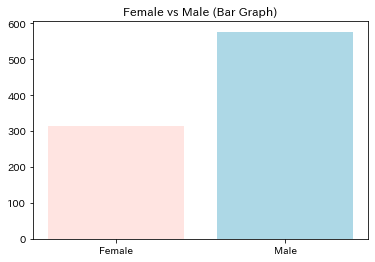

In [6]:
# 図示
show_chart(df_train)

In [7]:
# テストデータ
df_test = pd.read_csv(csv_path + fname2 +'.csv')
df_test.shape

(418, 11)

In [8]:
df_test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


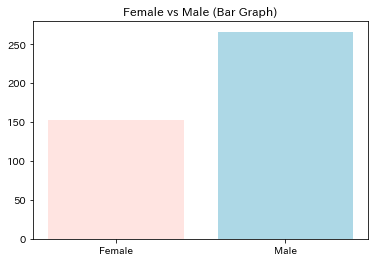

In [9]:
# 図示
show_chart(df_test)

## データ前処理

In [1]:
# 　学習に合わせてデータ前処理を行う

## 機械学習（AutoML）

- [AutoML](https://docs.h2o.ai/h2o/latest-stable/h2o-docs/automl.html)
- [AutoML Modelling](http://docs.h2o.ai/h2o/latest-stable/h2o-py/docs/modeling.html#h2oautoml)

#### H2Oaiの起動

In [10]:
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "13.0.2" 2020-01-14; OpenJDK Runtime Environment (build 13.0.2+8); OpenJDK 64-Bit Server VM (build 13.0.2+8, mixed mode, sharing)
  Starting server from /Users/hiroyasu.komaki/.pyenv/versions/3.7.4/lib/python3.7/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/cr/k_wktw_j2pv6tbndmc83x92r0000gp/T/tmp167nndd4
  JVM stdout: /var/folders/cr/k_wktw_j2pv6tbndmc83x92r0000gp/T/tmp167nndd4/h2o_hiroyasu_komaki_started_from_python.out
  JVM stderr: /var/folders/cr/k_wktw_j2pv6tbndmc83x92r0000gp/T/tmp167nndd4/h2o_hiroyasu_komaki_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Asia/Tokyo
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.30.0.1
H2O_cluster_version_age:,1 month and 13 days
H2O_cluster_name:,H2O_from_python_hiroyasu_komaki_lup50i
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,4 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"accepting new members, healthy"


#### （H2Oai用）Dataset生成

In [11]:
train = h2o.H2OFrame(df_train)
test = h2o.H2OFrame(df_test)

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


In [12]:
#drop passengerId from data set
passId = test['PassengerId']
train = train.drop('PassengerId',axis =1)
test = test.drop('PassengerId',axis =1)

#identify predictors and labels
x = train.columns
y = 'Survived'
x.remove(y)

#for binary classification, lables should be a factor
train[y] = train[y].asfactor()

#### 機械学習モデルの生成

In [13]:
aml_ti = H2OAutoML(max_runtime_secs= 120,max_models= 10, seed= 7,nfolds= 10)
aml_ti.train(x = x, y = y, training_frame = train)

AutoML progress: |████████████████████████████████████████████████████████| 100%


In [14]:
# 学習結果の表示
lb_ti = aml_ti.leaderboard
lb_ti

model_id,auc,logloss,aucpr,mean_per_class_error,rmse,mse
GBM_4_AutoML_20200516_215625,0.879206,0.405163,0.85872,0.185457,0.353374,0.124873
StackedEnsemble_BestOfFamily_AutoML_20200516_215625,0.87592,0.401633,0.858822,0.180735,0.351661,0.123665
GBM_3_AutoML_20200516_215625,0.875622,0.407747,0.858375,0.186559,0.3547,0.125812
DRF_1_AutoML_20200516_215625,0.875028,0.478903,0.851094,0.190466,0.360266,0.129792
GBM_2_AutoML_20200516_215625,0.873734,0.443805,0.840569,0.189387,0.370156,0.137016
StackedEnsemble_AllModels_AutoML_20200516_215625,0.872037,0.406038,0.853484,0.180256,0.353587,0.125024
XGBoost_1_AutoML_20200516_215625,0.867122,0.429004,0.833034,0.177835,0.358577,0.128578
XGBoost_3_AutoML_20200516_215625,0.864429,0.430321,0.843004,0.173449,0.36015,0.129708
XGBoost_2_AutoML_20200516_215625,0.864339,0.427483,0.836962,0.191473,0.363355,0.132027
GBM_1_AutoML_20200516_215625,0.863881,0.434239,0.840457,0.182653,0.368459,0.135762


In [15]:
# 学習済みモデルの決定
model = aml_ti.leader
print(model.model_id)

GBM_4_AutoML_20200516_215625


## 学習済みモデルでの予測実行

In [16]:
#prediction
pred = model.predict(test)

gbm prediction progress: |████████████████████████████████████████████████| 100%


/Users/hiroyasu.komaki/.pyenv/versions/3.7.4/lib/python3.7/site-packages/h2o/job.py:70: UserWarning: Test/Validation dataset column 'Cabin' has levels not trained on: [A11, A18, A21, A29, A9, B10, B11, B24, B26, B36, B45, B52 B54 B56, B61, C105, C116, C130, C132, C28, C31, C39, C51, C53, C55 C57, C6, C80, C89, C97, D22, D34, D38, D40, D43, E39 E41, E45, E52, E60, F, F E46, F E57]
  warnings.warn(w)


In [17]:
# predict
pred_df = pred.as_data_frame()
pred_df

,predict,p0,p1
0,0,0.960517,0.039483
1,0,0.834128,0.165872
2,0,0.916809,0.083191
3,1,0.706751,0.293249
4,1,0.456512,0.543488
...,...,...,...
413,0,0.932774,0.067226
414,1,0.025504,0.974496
415,0,0.917678,0.082322
416,0,0.983481,0.016519


In [18]:
passId_df = passId.as_data_frame()
passId_df

,PassengerId
0,892
1,893
2,894
3,895
4,896
...,...
413,1305
414,1306
415,1307
416,1308


In [19]:
resp_1 = pd.concat([passId_df,pred_df],axis=1,ignore_index = True)
resp_1.columns = ['PassengerId','predict','Survived.0','Survived.1']
# resp_1

In [20]:
resp_2 = pd.merge(df_test, resp_1, on='PassengerId')
# resp_2

In [21]:
df_pred = resp_2
df_pred.shape

(418, 14)

## 予測結果の評価

In [22]:
# 正解データ
df_correct = pd.read_csv(csv_path + fname3 +'.csv')
df_correct.shape

(418, 2)

In [23]:
# Merge two data
df_merge = pd.merge(df_pred, df_correct, on='PassengerId', how='inner')
df_merge.shape

(418, 15)

#### 答え合わせ

In [24]:
for index, row in df_merge.iterrows():
    n1 = row['Survived.0']
    n2 = row['Survived.1']
    if n1 > n2:
        a = 0
    elif n1 < n2:
        a = 1
    else:
        a = 9
    df_merge.at[index, 'Prediction'] = a
    
    n3 = row['Survived']
    if a == n3:
        df_merge.at[index, 'Result1'] = 'True'
    else:
        df_merge.at[index, 'Result1'] = 'False'
    if n3 == 0:
        df_merge.at[index, 'Result2'] = 'Negative'
    else:
        df_merge.at[index, 'Result2'] = 'Positive'

In [25]:
df_result = pd.DataFrame(df_merge['Result1'].value_counts())
df_result.head()

,Result1
True,365
False,53


([<matplotlib.patches.Wedge at 0x12f5dcb50>,
 [Text(0.27151959425140254, -0.6451954044609692, 'True'),
  Text(-0.27151962445517874, 0.645195391750219, 'False')],
 [Text(0.23273108078691646, -0.5530246323951166, '87.3%'),
  Text(-0.2327311066758675, 0.5530246215001877, '12.7%')])

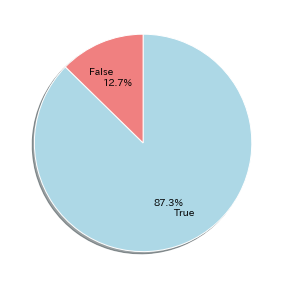

In [26]:
# 円グラフで表示
plt.figure(figsize=(10, 5))

x = np.array(df_result['Result1'])
label = ["True", "False"]
color = ["lightblue", "lightcoral"]

plt.pie(x,
        labels=label,
        labeldistance=0.7,
        colors=color, 
        counterclock=False, 
        startangle=90,
        wedgeprops={'linewidth': 1, 'edgecolor':"white"},
        autopct="%1.1f%%",
        shadow=True)

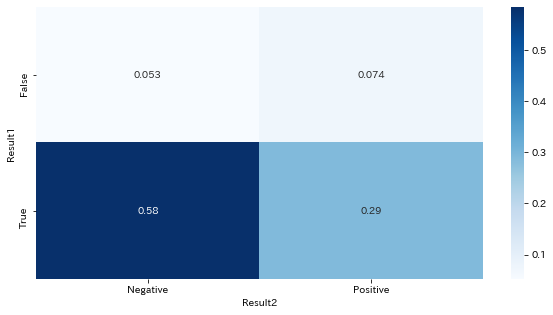

In [27]:
df_result2 = pd.crosstab(df_merge['Result1'], df_merge['Result2'], normalize=True)

# ヒートマップで表示
plt.figure(figsize=(10, 5))
sns.heatmap(data=df_result2, annot=True, cmap='Blues')

## 学習済みモデルの保存
http://docs.h2o.ai/h2o/latest-stable/h2o-docs/save-and-load-model.html

In [28]:
# save the model
model_path = h2o.save_model(model=model, path=model_path, force=True)
print(model_path)

/Users/hiroyasu.komaki/h2oai-bigdata-pilot/sample_code/h2oai/model/GBM_4_AutoML_20200516_215625
